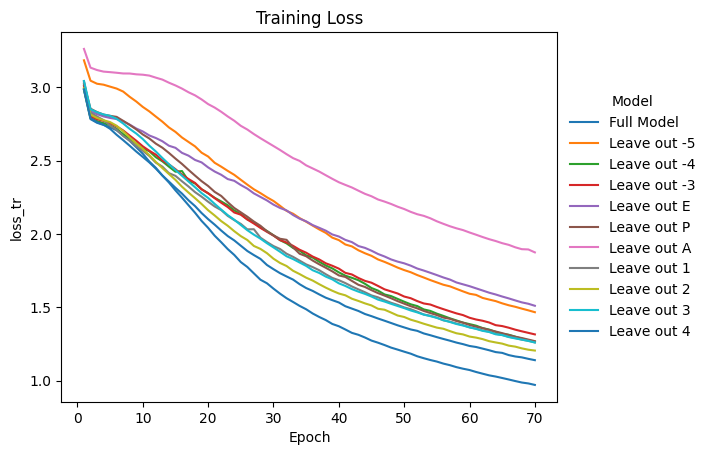

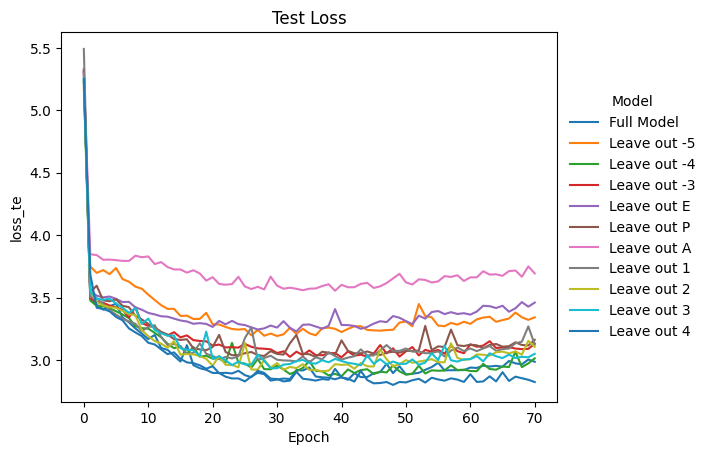

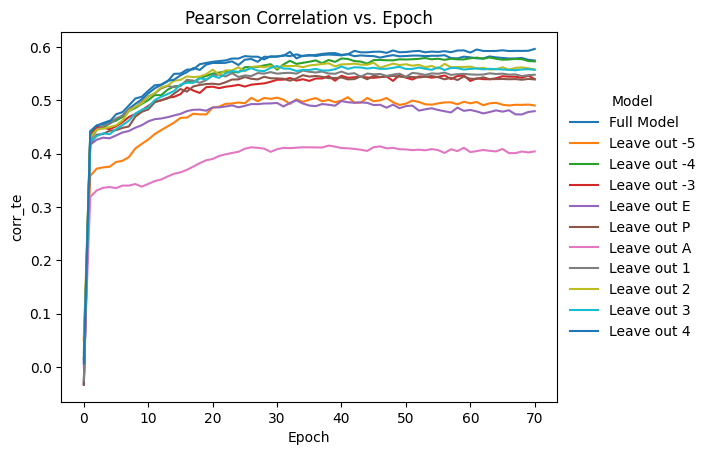

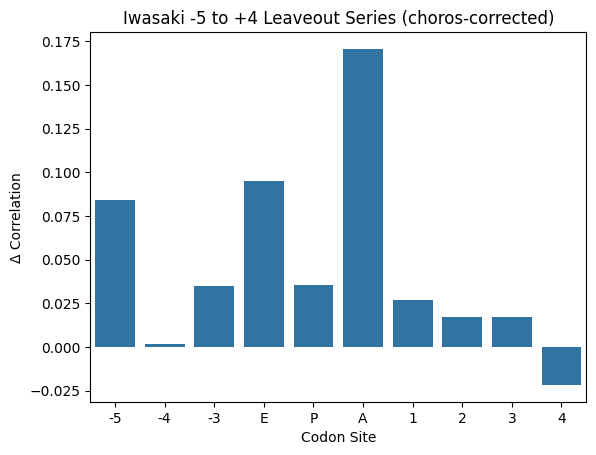

In [10]:
import torch
from torch import nn
import pickle
import numpy as np
from Bio import SeqIO
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# sys.path.append("src/")
# from src import legend_kwargs

def legend_kwargs():
    # Commonly used kwargs for figure legends
    kwargs = {
        "frameon" : False, 
        "bbox_to_anchor" : (1, 0.5), 
        "loc" : "center left"}
    return kwargs

model_dir = "processed-data/choros_iwasaki/models"
full_df = pd.read_csv(f"{model_dir}/ixnos_n5p4_full_loss_by_epoch.csv", index_col=0)
r_full = full_df.iloc[-1]["corr_te"].item()

named_sites = {
    0: "A",
    -1: "P",
    -2: "E"
}

comps = {}

fig, ax0 = plt.subplots()
ax0.set_title("Training Loss")
ax0.set_xlabel("Training Loss")
fig, ax1 = plt.subplots()
ax1.set_title("Test Loss")
ax1.set_xlabel("Test Loss")
fig, ax2 = plt.subplots()
ax2.set_title("Pearson Correlation vs. Epoch")
ax2.set_xlabel("Pearson Correlation")

sns.lineplot(full_df, x = range(len(full_df)), y="loss_tr", ax=ax0, label="Full Model")
sns.lineplot(full_df, x = range(len(full_df)), y="loss_te", ax=ax1, label="Full Model")
sns.lineplot(full_df, x = range(len(full_df)), y="corr_te", ax=ax2, label="Full Model")

for leaveout in range(-5, 5):
    res = pd.read_csv(f"{model_dir}/ixnos_n5p4_leaveout_{leaveout}_loss_by_epoch.csv", index_col=0)
    if leaveout in named_sites.keys():
        leaveout = named_sites[leaveout]
    sns.lineplot(res, x = range(len(res)), y="loss_tr", ax=ax0, label=f"Leave out {leaveout}")
    sns.lineplot(res, x = range(len(res)), y="loss_te", ax=ax1, label=f"Leave out {leaveout}")
    sns.lineplot(res, x = range(len(res)), y="corr_te", ax=ax2, label=f"Leave out {leaveout}")
    r_leaveout = res.iloc[-1]["corr_te"].item()
    delta_r = r_full - r_leaveout
    comps[leaveout] = delta_r

for ax in [ax0, ax1, ax2]:
    ax.legend(title="Model", **legend_kwargs())
    ax.set_xlabel("Epoch")
plt.show()


sns.barplot(comps)
plt.title("Iwasaki -5 to +4 Leaveout Series (choros-corrected)")
plt.ylabel("\u0394 Correlation")
plt.xlabel("Codon Site")
plt.show()

# Since these results don't look good, let's take a look at how much choros is correcting counts

In [11]:
df = pd.read_csv("processed-data/choros_iwasaki/outputs/iwasaki_bam.csv").dropna()
df

,transcript,cod_idx,d5,d3,f5,f3,gc,count,correct_100
0,ENST00000493442.1,102,15,10,TGC,ACT,0.321429,2.000000e+00,2.104242e+00
1,ENST00000234590.7,19,15,10,TCT,TTG,0.428571,1.600000e+01,1.179755e+01
2,ENST00000264258.6,120,15,9,AAA,GAT,0.148148,4.000000e+00,2.689485e+00
3,ENST00000372899.4,844,15,10,AAA,ACT,0.214286,2.775930e-01,3.932757e-01
4,ENST00000372901.1,844,15,10,AAA,ACT,0.214286,7.224069e-01,1.023459e+00
...,...,...,...,...,...,...,...,...,...
4950058,ENST00000472837.4,42,15,11,CTG,CTG,0.448276,3.624865e-11,2.030624e-11
4950059,ENST00000614064.3,42,15,11,CTG,CTG,0.448276,4.860194e-10,2.722647e-10
4950060,ENST00000614386.1,42,15,11,CTG,CTG,0.448276,4.860194e-10,2.722647e-10
4950061,ENST00000625377.1,42,15,11,CTG,CTG,0.448276,2.178221e-11,1.220224e-11


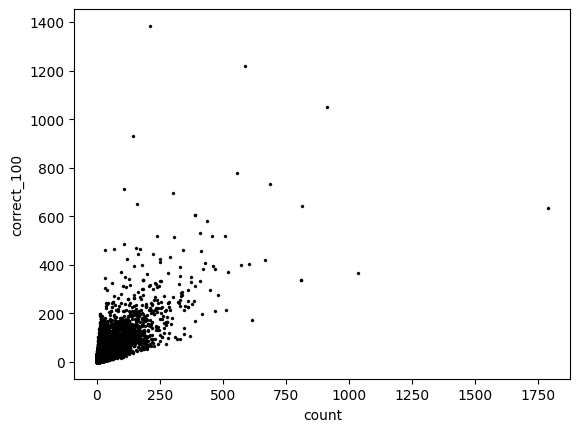

In [13]:
sns.scatterplot(
    df, 
    x='count',
    y='correct_100',
    s=5, edgecolor=None, c='k',
)
plt.show()

In [17]:
df_te = pd.read_csv("processed-data/choros_iwasaki/te_ixnos_set_trunc_20_20.data_table.txt", sep="\t")
df_tr = pd.read_csv("processed-data/choros_iwasaki/tr_ixnos_set_trunc_20_20.data_table.txt", sep="\t")
df_te_tr = pd.concat([df_te, df_tr])
df_te_tr.head()

,gene,cod_idx,cod_seq,raw_cts,corrected_cts,scaled_cts
0,ENST00000001008.5,20,GAG,0.000000,0.000000,0.000000
1,ENST00000001008.5,21,GGA,0.684110,0.997961,0.128558
2,ENST00000001008.5,22,GTG,6.328484,3.991867,0.514235
3,ENST00000001008.5,23,GAC,7.518333,3.991855,0.514234
4,ENST00000001008.5,24,ATC,1.705335,1.995933,0.257118


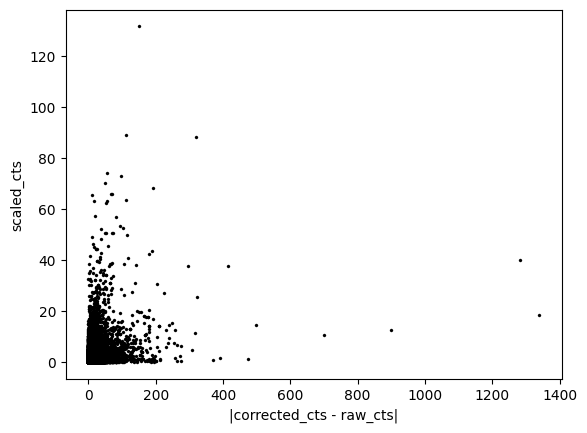

In [24]:
delta = "|corrected_cts - raw_cts|"
df_te_tr[delta] = np.abs(df_te_tr['corrected_cts'] - df_te_tr['raw_cts'])
sns.scatterplot(
    df_te_tr,
    x=delta, 
    y='scaled_cts',
    c='k', s=5, edgecolor=None,
)
# plt.yscale("log")
plt.show()

In [57]:
def initialize_multiplot(n_plots, n_cols=3, **kwargs):
    '''Given a certain number of plots, initialize subplots that have that many
    plots divided into n_cols columns. 
    '''    
    n_rows = n_plots // n_cols+1 if n_plots % n_cols != 0 else n_plots // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, **kwargs)
    # Remove any plots that won't be used
    lastrow = n_rows - 1
    first_unused = (n_plots ) % n_cols
    if first_unused != 0:
        for col in range(first_unused, n_cols):
            axs[lastrow, col].remove()
    return fig, axs, get_axes(n_plots, n_cols)


def get_axes(n_plots, n_cols):
    '''Generator to use with the above initialize_multiplots function that gets 
    the correct axis indices as you iterate your plotting function

    USAGE: 
    fig, axs, which_ax = initialize_multiplot(n_cols, n_plots)
    for ...:
        row, col = next(which_ax)
        plot_fxn(*args, ax=axs[row, col])
    '''
    idx = 0
    n_rows = n_plots//n_cols+1 if n_plots%n_cols!=0 else n_plots//n_cols
    while idx <= n_plots-1:
        row = idx // n_cols
        col = idx % n_cols
        yield row, col
        idx+=1

In [64]:
# fig, axs, which = initialize_multiplot(500, n_cols=100, figsize=(400, 20))
# for gene in df_te_tr["gene"].unique():
#     # gene = df_te_tr["gene"].unique()[0]
#     row, col = next(which)
#     df_g = df_te_tr[df_te_tr["gene"] == gene]
#     a = .6
#     sns.lineplot(
#         df_g,
#         x='cod_idx',
#         y='raw_cts',
#         linewidth=1,
#         alpha=a, c='m', label="raw",
#         ax=axs[row, col]
#     )
#     sns.lineplot(
#         df_g,
#         x='cod_idx',
#         y='corrected_cts',
#         linewidth=1,
#         alpha=a, c='c', label="corrected",
#         ax=axs[row, col]
#     )
#     axs[row, col].set_xticks([])
#     axs[row, col].set_yticks([])
#     axs[row, col].set_ylabel("")
#     axs[row, col].set_xlabel("")
#     axs[row, col].set_xlim(min(df_g["cod_idx"]), max(df_g["cod_idx"]))
#     axs[row, col].set_title(gene)
#     axs[row, col].legend().remove()
# axs[row, col].legend(**legend_kwargs())
# plt.show()

<Axes: xlabel='cod_idx'>

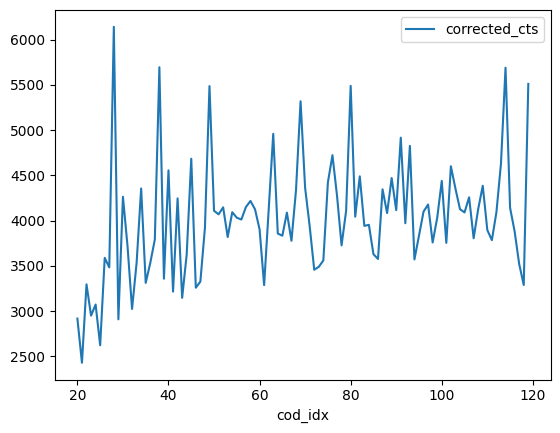

In [74]:
sns.lineplot(pd.DataFrame(df_te_tr.groupby('cod_idx')['corrected_cts'].sum()).iloc[:100])

In [83]:
sys.path.append("scripts/")
from ixnos import iXnos
import torch
model = iXnos(min_codon=-3, max_codon=2)
model.load_state_dict(torch.load("processed-data/iwasaki/models/ixnos_n3p2_full.pth"))
model.eval()
cit = pd.read_csv("processed-data/citrine_fluorescence_expanded.csv")#.groupby("cit")["seq"].unique()

/tmp/ipykernel_35258/1187445772.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("processed-data/iwasaki/models/ixnos_n3p2_full.pth"))


In [90]:
names, scores = [], []

for cit_seq in cit["cit"].unique():
    names.append(cit_seq)
    seq = cit.loc[cit['cit'] == cit_seq, "seq"].unique().item()
    cts = model.predict_elongation(seq, profile=True)
    scores.append(cts)

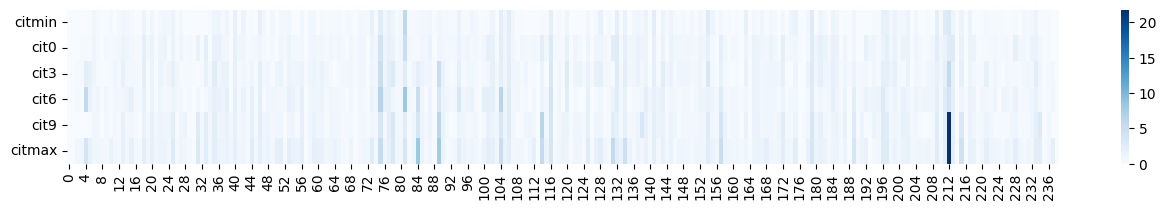

In [108]:
fig, ax = plt.subplots(figsize=(16, 2))
sns.heatmap(pd.DataFrame(dict(zip(names, scores))).T, cmap="Blues", ax=ax,)
plt.show()

In [106]:
cod = [i for j in iXnos.get_aa_to_codon().values() for i in j]
len([i for i in cod if "T" in i]) / len(cod)

0.578125